<a href="https://colab.research.google.com/github/ms0017/GANs_exploration/blob/master/GANs_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount G-Drive on colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Next, clone StyleGAN2 ADA PyTorch from GitHub.
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 745.00 KiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 108 kB 12.8 MB/s 


In [3]:
# Verify that StyleGAN has been cloned.
!ls /content/stylegan2-ada-pytorch/

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


In [4]:
# Import required packages
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy
from tqdm.notebook import tqdm

In [5]:
# This function takes short seed numbers "seed" eg 6600 and expands them into a 512 latent vector, which is a floating point value
# The seed value is easier to represent in code than a 512 value vector. However, while a small change to the latent vector 
# results in a small change to the image, even a small change to the seed value will produce a radically different image.
# One can think of the latent vector as the DNA
def seed2vec(G, seed):
  """
  seed2vec: converts seed to latent vector

  param G: 
  param seed: the specified seed

  return int: a latent vector
  """
  return np.random.RandomState(seed).randn(1, G.z_dim)

In [6]:
def display_image(image):
  """
  display_image: displays input image

  param image: image to be displayed
  """
  plt.axis('off')
  plt.imshow(image)
  plt.show()

In [8]:
def generate_image(G, z, truncation_psi):
  """
  generate_image: generates image given params
  param G: Neural Net
  param z: 512 lantent vectors/ seeds
  param truncation_psi: used by stylegan2 to make images clearer
  """
  # Render images for dlatents initialized from random seeds.
  Gs_kwargs = {
      'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
      'randomize_noise': False
  }
  if truncation_psi is not None:
      Gs_kwargs['truncation_psi'] = truncation_psi

  label = np.zeros([1] + G.input_shapes[1][1:])
  images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
  return images[0]

In [9]:
def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

In [10]:
def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [11]:
def expand_seed(seeds, vector_size):
  result = []
  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

In [12]:
def download_torch_pretrained_instance(device):
  #URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
  URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
  print(f'Loading networks from "{URL}"...')
  with dnnlib.util.open_url(URL) as f:
      G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
  return G

In [13]:
def get_images(G, device):
  # Choose your own starting and ending seed.
  SEED_FROM = 2000
  SEED_TO = 2003

  # Generate the images for the seeds.
  for i in range(SEED_FROM, SEED_TO):
    print(f"Seed {i}")
    z = seed2vec(G, i)
    img = generate_image(device, G, z)
    display_image(img)

In [14]:
def explore_seed(G):
  vector_size = G.z_dim
  # range(8192,8300)
  seeds = expand_seed( [8192+1,8192+9], vector_size)
  #generate_images(Gs, seeds,truncation_psi=0.5)
  print(seeds[0].shape)

In [15]:
def morph_video(G, device):
  # Choose your seeds to morph through and the 
  # number of steps to take to get to each.
  SEEDS = [2000,2003,2001]
  STEPS = 100

  # Remove any prior results
  !rm /content/results/* 
  os.makedirs("./results/", exist_ok=True)

  # Generate the images for the video.
  idx = 0
  for i in range(len(SEEDS)-1):
    v1 = seed2vec(G, SEEDS[i])
    v2 = seed2vec(G, SEEDS[i+1])

    diff = v2 - v1
    step = diff / STEPS
    current = v1.copy()

    for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
      current = current + step
      img = generate_image(device, G, current)
      img.save(f'./results/frame-{idx}.png')
      idx+=1
  
  # Link the images into a video.
  !ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

In [16]:
def download_video():
  from google.colab import files
  files.download('movie.mp4')

cuda
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Seed 2000
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


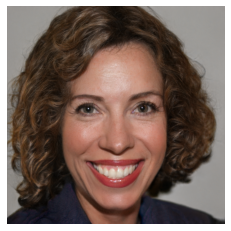

Seed 2001


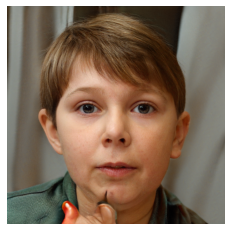

Seed 2002


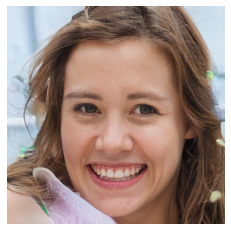

(1, 512)
rm: cannot remove '/content/results/*': No such file or directory


Seed 2000:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 2003:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
if __name__== "__main__":
    device = torch.device('cuda')
    print(device)
    G = download_torch_pretrained_instance(device)
    get_images(G, device)
    explore_seed(G)
    morph_video(G, device)
    download_video()